<a href="https://colab.research.google.com/github/orspiegel/Algorithms/blob/main/Copy_of_Ex6_Neural_Networks_SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><b>Neural Networks</b></center></h1>
<h3><center>Exercise 6</center></h3>

Your Names:
<font color='red'>
FirstName1 LastName1, 123456789
FirstName2 LastName2, 987654321
</font>


____________

In this exercise we will:
Implement the SimCLR algorithm and train a model on ImageNet-5.


**Instructions:**
- Create a copy of this notebook and implement your code in it.
- Make sure you don't leave empty cells or empty answers.
- When you finish the assignment, share the notebook with the course email: nn4ns2023@gmail.com
- submission deadline: 29/6/2023
- Your submission should includ the outputs (don't delete them before the submission)

### **1. Setup**
Before running code on Colab:
- Go to "Runtime" -> "Change runtime type", and make sure to choose "GPU" for Hardware accelerator.

### **2. Self Supervised Learning (100 points)**

In this section we are going to implement the simCLR loss and train a model on a small version of ImageNet called ImageNet-5, which has only 5 categories instead of 1000.

[simCLR](https://arxiv.org/pdf/2002.05709.pdf)  (A Simple Framework for Contrastive Learning of Visual Representations) was proposed by Chen et al in 2020 for the "Unsupervised representation learning" task.
The goal of this task is to learn a good representation of the data without labels!
The authors present a simple self-supervised framework for contrastive learning of visual representations.

Some basic concepts before we start:

**Self-supervised learning:**
Self-supervised learning is a learning technique using supervised learning with unlabeled data. The idea is to create labels for another task (called pretext task) that are easy to create automatically and are informative about the main task .

**Contrastive Learning:**
Contrastive learning is the idea of learning representations by enforcing a similar representation of elements that are known to be semantically equivalent, and push away representations of dissimilar elements.

**SimCLR:**
The idea of SimCLR framework is simple:
An image is taken and random transformations are applied to it to get a pair of two augmented images
$x_i$ and $x_j$. Each image in that pair is passed through an encoder to get representations. Then a non-linear fully connected layer is applied to get representations z. The task is to maximize the similarity between these two representations
$z_i$ and $z_j$ for the same image.


<center>
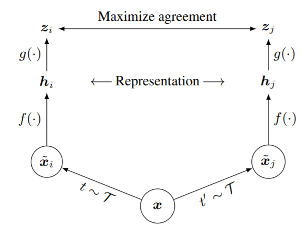

Go over the [paper](https://arxiv.org/pdf/2002.05709.pdf) and this [tutorial](https://amitness.com/2020/03/illustrated-simclr/) to get a better idea of how simCLR works and the intuition behind it.

#### **2.1 Preparations**

We start by downloading the data and creating a custom pytorch dataset.
<br> **Note:** you can use this command to install any git repository on colab. Many papers upload their code to github. This makes it easier to test or use their implementation with your dataset.

In [ ]:
# download imagenet-5
!git clone https://github.com/thunderInfy/imagenet-5-categories.git

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image
import os

In [ ]:
class ImageNetFive(Dataset):
  def __init__(self, root_dir, transform, augment=True):
    self.root_dir = root_dir
    self.augment = augment
    self.transform = transform
    self.class_mappings = {'car': 0, 'dog': 1, 'elephant': 2, 'cat': 3, 'airplane': 4}
    imgs_path = np.array(list(sorted(os.listdir(self.root_dir))))
    labels = np.array([self.class_mappings[x.split('_')[0]] for x in imgs_path])
    # reduce number of samples per class
    self.imgs_path = []
    self.labels = []
    for l in np.unique(labels):
      idx = np.where(labels == l)[0][:15].astype(int)
      self.imgs_path += imgs_path[idx].tolist()
      self.labels += labels[idx].tolist()

  def __len__(self):
    return len(self.imgs_path)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    # load image from disk
    img = Image.open(os.path.join(self.root_dir, self.imgs_path[idx]))
    # get its label
    label = self.labels[idx]

    if self.augment:
      # training mode - create two augmentations
      aug_image1 = self.transform(img)
      aug_image2 = self.transform(img)
      sample = {'image1': aug_image1, 'image2': aug_image2, 'label': label}
    else:
      # test mode - no need for augmentations
      image = self.transform(img)
      sample = {'image': image, 'label': label}

    return sample

#### **2.2 Augmentations (10 points)**

Before we dive into implementing the loss itself, let's implement a crucial part of the algorithm: Augmenting Images.

During training, we are going to pick an image from the dataset and apply transformations to it to create two augmented images.
We would later want the features of those two images to be similar in the embedding space but different from other images in the data.

To apply transformations to an image we can use ```torchvision.transforms```.
Go over the code below and see how the transformation for train images (```transform_train```) and test images (```transform_test```) are defined.

In [ ]:
# transformation on train images
transform_train = transforms.Compose(
    [
      transforms.Resize((250, 250)), # resize image
      transforms.RandomHorizontalFlip(p=0.5), # AUGMENTATION: Random Horizontal Flip
      transforms.RandomResizedCrop(224), # AUGMENTATION: Random Cropping
      transforms.ToTensor(), # numpy array to tensor
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize the image
     ])

# basic transformation on test images
transform_test = transforms.Compose(
    [
      transforms.Resize((224, 224)), # resize image
      transforms.ToTensor(), # numpy array to tensor
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize the image
    ])

Note that here, we have declared two types of ```transforms```: ```transform_train``` and ```transform_test```.
During training we are going to load train images and apply ```transform_train``` on them **twice** (meaning, creating two image augmentations). During evaluation, we don't want to create augmentations, so only basic transformations are applied (resizing and normalizing, which should be done to every image in the data). For that we have ```transform_test```.

In the above ```transform_train``` we apply only two simple  augmentations to an image: ```RandomHorizontalFlip``` and ```RandomResizedCrop```. ```RandomHorizontalFlip``` flips the image randomly with a given probability (in our case 50%), while ```RandomResizedCrop``` crops the image to random size and aspect ratio.

See the official documentation for many more: [Pytorch Transforms](https://pytorch.org/vision/stable/transforms.html#functional-transforms).

Copy ```transform_train``` from above and add at least two more types of augmentations. You can use pytorch transforms or implement augmentations yourself.

In [ ]:
######################
### YOUR CODE HERE ###
######################
# transform_train = ...

We can now create datasets and dataloaders

In [ ]:
# train-set with augmentations
train_dataset = ImageNetFive(root_dir="imagenet-5-categories/train", transform=transform_train, augment=True)
# set train loader with augmentations
train_loader = DataLoader(train_dataset, batch_size=75, shuffle=True)

# train set without augmentation
raw_train_dataset = ImageNetFive(root_dir="imagenet-5-categories/train", transform=transform_test, augment=False)
# set train loader without augmentation
raw_train_loader = DataLoader(raw_train_dataset, batch_size=50, shuffle=True)

# test-set
test_dataset = ImageNetFive(root_dir="imagenet-5-categories/test", transform=transform_test, augment=False)
# test loader
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

Let's see that it works as expected. We take a sample from the ```raw_train_dataset``` (the dataset where no augmentations are applied) and from ```train_dataset``` (dataset with augmentations).

In [ ]:
# take the first sample from raw_train_set
first_raw_sample = raw_train_dataset[0]

# take one sample (=two augmentations) from train_dataset
first_aug_sample = train_dataset[0]
# the result is a dicrtionary, so print its keys
print(first_aug_sample.keys())

From the output we can see that a sample of the train set with augmentations consists of two images: ```image1``` and ```image2``` which are both augmentations of an original ImageNet image.

Let's visualize them:

In [ ]:
# first visualize original image
plt.imshow(first_raw_sample['image'].permute(1, 2, 0))

In [ ]:
# now visualize the two augmentations
plt.subplot(1,2,1)
plt.imshow(first_aug_sample['image1'].permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(first_aug_sample['image2'].permute(1, 2, 0))

You should be able to see two *similar* images that were created from an original image.

#### **2.4 Contrastive Loss (50 points)**



Now we can implement the loss function.
SimCLR uses a contrastive loss called "NT-Xent loss" (Normalized Temperature-Scaled Cross-Entropy Loss)

The loss is defined for a pair of images as:

$$l_{i,j} = - \log{\frac{e^{sim(z_i,z_j)/\tau}}{\sum_{k=1}^{2N}{I_{[k\not=i]}e^{sim(z_i,z_k)/\tau}}}}$$


where:
- $z_i$ and $z_j$ are 1d representations (features) vectors of an augmented image $i$ and an augmented image $j$ respectively.
- 2N is the batch size (N for the first type of augmentations + N for the second type of augmentations).
- $sim(x,y)$ is the similarity function between two vectors **x** and **y**.
- $\tau$ is a temperature parameter used to scale the value returned by the similarity function.

The loss for one single batch is then the contrastive loss between every two instances in the batch:

$$ L = \frac{1}{2N} \sum_{i=1}^{N}{l(2i-1, 2i) + l(2i,2i-1)}  \quad \mathbf{(Eq. 1)}$$

The similarity function $sim(x,y)$ used in SimCLR is the **cosine similarity** between x and y. Which is simply the dot product of two normalized vectors.

$$ sim(x,y) = \frac{x^T \cdot y}{||x||||y||} \quad \mathbf{(Eq. 2)}$$

Implement the function ```cosine_similarity``` and ```contrastive_loss``` below. Don't forget to use torch functions so we can later do backpropagation and pass gradients

**IMPORTANT:** You are **not** allowed to use ```nn.CosineSimilarity```, ```nn.CrossEntropyLoss``` or ```nn.Softmax```.
Follow the comments we left for you in the cell, they should help you implement the loss efficiently.

For numerical stability, use this log rule:

$$ \log{\frac{e^x}{\sum_y{e^y}}} = \log(e^x) - \log(\sum_y{e^y}) = x - \log(\sum_y{e^y}) \quad \mathbf{(Eq. 3)}$$

<font color='green'><b>
Try to implement the functions below without loops!
</b></font>

In [ ]:
def pairwise_cosine_sim(X, Y):
  '''
  General implementation of Eq (2).
  The function calculates the cosine similarity between each pair in X and Y:
  X and Y are two batches of vectors and the function calculates the cosine similarity
  between each pair and return a matrix with shape [|x|,|y|] where cell [i,j] is
  the cosine similarity between X[i,:] and Y[j,:].
  '''
  ######################
  ### YOUR CODE HERE ###
  ######################
  # Hint: Do not forget to normalize the vectors!
  ######################

def contrastive_loss(aug1_batch, aug2_batch, temperature=0.07):
  '''
  Implementation of Eq (1).
  The function calculates the contrastive loss for the given image augmentation
  batches (aug1_batch and aug2_batch).
  '''
  batch_size = aug1_batch.shape[0]
  # 1. concat both batches to one big batch.
  #    (Result shape should be: [2*batch_size, feat_dim])
  representations = torch.cat([aug1_batch, aug2_batch], dim=0)

  # 2. compute similarity between each pair in representations matrix.
  #    use ```pairwise_cosine_sim``` funciton.
  #    (Result shape should be: [2*batch_size, 2*batch_size])
  similarity_matrix = pairwise_cosine_sim(representations, representations)

  # 3. divide values by temperature
  #    (Result shape should be: [2*batch_size, 2*batch_size])
  similarity_matrix = torch.div(similarity_matrix, temperature)

  # 4. calculate the denominator in the loss:
  #    4.1.  apply exponent on all values
  #          (Result shape should be: [2*batch_size, 2*batch_size])
  exp_similarity_matrix = torch.exp(similarity_matrix)
  #    4.2.  zero out similarities between samples to themselfs (remove the diagonal)
  #          and calculate the sum for each row in the matrix
  #          (Result shape should be: [2*batch_size])
  denom = torch.sum(exp_similarity_matrix, dim=1) - torch.diag(exp_similarity_matrix)

  # 5. calculate the log probabilities
  #   5.1. log rule [Eq (3)]: # log(e^x/sum(y)) = x - log(sum(y))
  #        (Result shape should be: [2*batch_size,2*batch_size])
  log_prob = similarity_matrix - torch.log(denom)
  #   5.2. take only the positives (loss numerator):
  #        cells where the samples should be similar we want to maximize the similarity between them
  #        (Result shape should be: [2*batch_size])
  l_pos = torch.diag(log_prob, batch_size)
  r_pos = torch.diag(log_prob, -batch_size)
  log_prob_pos = torch.cat([l_pos, r_pos])

  #  6. multiply by -1 and compute the mean (sum of log probabilities/(2*batch_size))
  #    (Result shape should be: Scalar)
  loss = -1 * log_prob_pos.sum() / (2*batch_size)
  return loss

Test your implementation with the dummy example below:

In [ ]:
batch_1 = torch.tensor([[-0.83483301, -0.16904167, 0.52390721],[ 0.70374682, -0.18682394, -0.68544673]])
batch_2 = torch.tensor([[-0.83455951, -0.16862266, 0.52447767],[ 0.76652431,  0.61500886,  0.18494479]])
contrastive_loss(batch_1, batch_2, temperature=1)

If you implemented it correctly, the loss would be ```0.4068```.

**Q1:**
What is the goal of the temperature parameter $\tau$? How does it affect the loss?

**A1:**
<font color='red'>
YOUR ANSWER HERE!
</font>


**Q2:**
**a.** What will be the value of the loss for a batch with 2N ***identical*** samples?
**b.** In that case, will different temperature values change the loss?

**A2**:
<font color='red'>
YOUR ANSWER HERE!
</font>


**Q3:** How does the batch size affect the contrastive loss? Does large batch size is better than small batch size when training a model with contrastive loss?

Hint: Note that the loss calculates the exponent of the cosine similarity between each pair in the batch.

**A3**:

#### **2.5 Model (10 points)**

The model in the SimCLR framework is composed of two parts:

1. *Base Encoder* $f(\cdot)$ - A convolutional neural network without a classifier. Its goal is to extract features (image representations) for each augmented image that is passed through it.
Inputs: Augmented images $x_i$ and $x_j$
Outputs: $h_i$ and $h_j$ - vector representations of the two images.

2. *Projection Head* $g(\cdot)$ - A simple fully connected neural network that takes the output of the base encoder and learns to map them to final image representations.
Inputs: $h_i$ and $h_j$
Outputs: $z_i$ and $z_j$.

See the diagram below for visualization.

Note that the vectors $z_i$ and $z_j$ have lower dimensions than $h_i$ and $h_j$.

<center>
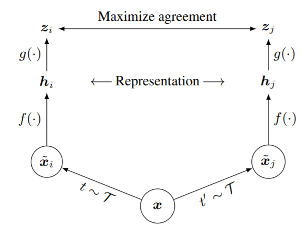

Create a resnet18 instance (using torchvision) as the base encoder, and replace the classifier head with a projection head.
The projection head architecture is as follows:

A **fully connected layer** with 100 units, a **relu activation**, another **fully connected layer** with 40 units, a **relu activation** and finally an **output layer** with 20 units (so the final features will have dimention=20).

In [ ]:
def create_simclr_model():
  # create new resnet18 as the base encoder
  simclr_model = torchvision.models.resnet18(pretrained=False)
  # change its classifier to a projection head
  ######################
  ### YOUR CODE HERE ###
  ######################
  return simclr_model

Let's implement a function for creating an SGD optimizer for a given model.

In [ ]:
def create_optimizer(model, lr, momentum=0.9):
  return optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#### **2.6 Training (10 points)**

We can now finally train the model on the data.
Implement the train function below. Use the ```contrastive loss``` you implemented above.

In [ ]:
def self_supervised_training(model, optimizer, train_dataloader, temperature=0.07,
                             num_epochs=10, print_freq=30, device="cuda"):
  # move model to device
  model = model.to(device)

  for epoch in range(num_epochs):
    model.train()
    for (idx, aug_batch) in enumerate(train_dataloader):
        ######################
        ### YOUR CODE HERE ###
        ######################
        loss_value = loss.cpu().data.item()

    if epoch % print_freq == 0:
      print(f"Epoch {epoch}, Contrastive loss={loss_value}")

  return model

In [ ]:
# hyper params
num_epochs = 30
lr=0.003

# Create new instance of the model
simclr_model = create_simclr_model()
# Create optimizer
simclr_opt = create_optimizer(simclr_model, lr=lr, momentum=0.9)
# Train the model
simclr_model = self_supervised_training(simclr_model, simclr_opt, train_loader,
                                        num_epochs=num_epochs, print_freq=5, device="cuda")


You should see the loss slowly decreasing at every epoch.

#### **2.7 Visualizations (20 points)**

So we trained the model for 10 epochs, and hopefully it now has good representations for each sample. That is, images from the same class are close to each other in the feature space.

We would like to visualize the features. The problem is that the features are high dimensional vectors, and we can't plot vectors with dim > 3.
What can we do?
We can use T-SNE!
t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

Let's visualize the train and test features using T-SNE:
1. Using the trained model, extract the features from both the raw train set (using ```raw_train_loader``` and from the test set (using ```test_loader```).
2. With T-SNE, reduce the dimension from 20 to 2.
3. Use matplotlib to plot **two separate** scatter plots - one for each set. Color samples with the same labels with the same color! ([This](https://stackoverflow.com/questions/47006268/matplotlib-scatter-plot-with-color-label-and-legend-specified-by-c-option) might help you. )

You can use [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for T-SNE.

In [ ]:
# set model in eval mode
_ = simclr_model.eval()

In [ ]:
feat_dim = 20

def extract_features_and_labels(model, dataloader):
  # create empty placeholders
  features = torch.empty((0, feat_dim))
  labels = torch.empty(0, dtype=torch.long)
  for (_, batch) in enumerate(dataloader):
    image = batch['image']
    curr_labels = batch['label']
    curr_feats = model(image.to("cuda"))
    features = torch.cat((features, curr_feats.cpu().detach()))
    labels = torch.cat((labels, curr_labels))
  return features.numpy(), labels.numpy()

# 1.1 Extract train features
train_features, train_labels = extract_features_and_labels(simclr_model, raw_train_loader)

# 1.2 Extract test features
test_features, test_labels = extract_features_and_labels(simclr_model, test_loader)

In [ ]:
# 2. Reduce dimention with t-sne (from 20-d vectors to 2-d vectors)
from sklearn.manifold import TSNE
######################
### YOUR CODE HERE ###
######################

In [ ]:
# 3. Plot the train and test features on a 2d plot using the embedded vectors extracted from TSNE
# Do not forget to color samples with the same color if they have the same label
classes = np.unique(train_labels)
plt.rcParams["figure.figsize"] = (13,5)
######################
### YOUR CODE HERE ###
######################

If you implemented everything correctly, you should see that features from the same class (same color) are close to each other in the feature space.

Now, you can change the data augmentations, hyperparameters etc. above.
Share the notebook with the best implementation!